<a href="https://colab.research.google.com/github/mnjkr123/pythonwebapps/blob/main/Radiology_Partner1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('filtered_radiology_data.csv')

# Preview the data
df.head()

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,...,HCPCS_Desc,HCPCS_Drug_Ind,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt
0,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Mri scan of brain without contrast,N,F,47,47,47,85.531915,65.043404,50.757872,52.837872
1,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Mri scan of brain before and after contrast,N,F,11,11,11,120.000000,105.180000,83.800000,83.950000
2,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Ct scan of chest without contrast,N,F,63,65,63,59.000000,48.898308,36.590769,36.336615
3,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Ct scan of chest with contrast,N,F,92,92,92,66.000000,51.451739,40.041196,40.162283
4,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Complete ultrasound scan of abdomen,N,F,17,17,17,48.294118,34.685882,24.111765,26.280000


In [ ]:
# Define mappings
MRI_CODES = ['70551', '70552', '70553']
CT_CODES = ['71250', '71260', '71270']
ULTRASOUND_CODES = ['76641', '76642', '76700', '76705']

def map_modality(code):
    if code in MRI_CODES:
        return 'MRI'
    elif code in CT_CODES:
        return 'CT'
    elif code in ULTRASOUND_CODES:
        return 'Ultrasound'
    else:
        return 'Other'

df['modality'] = df['HCPCS_Cd'].astype(str).apply(map_modality)

# Convert numeric fields
df['Tot_Srvcs'] = pd.to_numeric(df['Tot_Srvcs'], errors='coerce')
df['Avg_Mdcr_Alowd_Amt'] = pd.to_numeric(df['Avg_Mdcr_Alowd_Amt'], errors='coerce')
df['Rndrng_NPI'] = df['Rndrng_NPI'].astype(str)


In [ ]:
df_summary = df.groupby(['Rndrng_NPI', 'modality']).agg({
    'Tot_Srvcs': 'sum',
    'Avg_Mdcr_Alowd_Amt': 'mean'
}).reset_index()

In [ ]:
from sklearn.ensemble import IsolationForest

# Z-score normalization by modality
df_summary['Tot_Srvcs_Z'] = df_summary.groupby('modality')['Tot_Srvcs'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Prepare features
X = df_summary[['Tot_Srvcs_Z', 'Avg_Mdcr_Alowd_Amt']].fillna(0)

# Train Isolation Forest
clf = IsolationForest(contamination=0.03, random_state=42)
df_summary['outlier_flag'] = clf.fit_predict(X)

# 1 = inlier, -1 = outlier
df_summary['is_outlier'] = df_summary['outlier_flag'].map({1: 0, -1: 1})

# Show top outliers
outliers = df_summary[df_summary['is_outlier'] == 1]
outliers.head(10)

,Rndrng_NPI,modality,Tot_Srvcs,Avg_Mdcr_Alowd_Amt,Tot_Srvcs_Z,outlier_flag,is_outlier
5,1003002809,MRI,302,269.150298,0.917090,-1,1
101,1003059395,MRI,91,299.174233,-0.317412,-1,1
118,1003072950,MRI,724,205.803402,3.386094,-1,1
141,1003090093,CT,1057,178.772100,4.082638,-1,1
158,1003113010,MRI,100,260.028595,-0.264755,-1,1
182,1003145038,Ultrasound,556,148.949956,3.292746,-1,1
184,1003151671,MRI,278,234.305608,0.776673,-1,1
186,1003161993,Ultrasound,614,65.430443,3.712340,-1,1
205,1003187881,MRI,101,287.970192,-0.258904,-1,1
206,1003187881,Ultrasound,506,119.138956,2.931027,-1,1


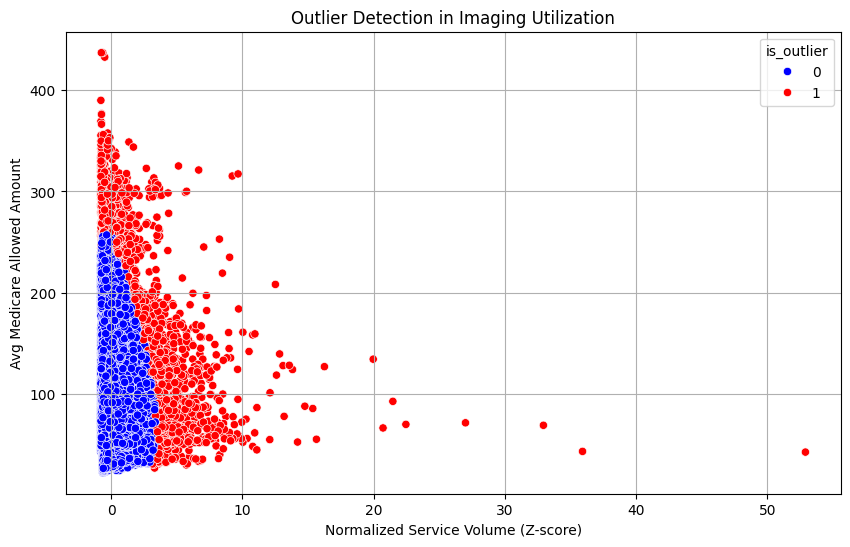

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_summary, x='Tot_Srvcs_Z', y='Avg_Mdcr_Alowd_Amt',
                hue='is_outlier', palette={0: 'blue', 1: 'red'})
plt.title('Outlier Detection in Imaging Utilization')
plt.xlabel('Normalized Service Volume (Z-score)')
plt.ylabel('Avg Medicare Allowed Amount')
plt.grid(True)
plt.show()


In [7]:
import pandas as pd

df = pd.read_csv('filtered_radiology_data.csv')

# Preview the data
df.head()

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,...,HCPCS_Desc,HCPCS_Drug_Ind,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt
0,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Mri scan of brain without contrast,N,F,47,47,47,85.531915,65.043404,50.757872,52.837872
1,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Mri scan of brain before and after contrast,N,F,11,11,11,120.000000,105.180000,83.800000,83.950000
2,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Ct scan of chest without contrast,N,F,63,65,63,59.000000,48.898308,36.590769,36.336615
3,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Ct scan of chest with contrast,N,F,92,92,92,66.000000,51.451739,40.041196,40.162283
4,1003002148,Owens,Justin,M,M.D.,I,243 Curtiss Rd,Ste 100,Barksdale Afb,LA,...,Complete ultrasound scan of abdomen,N,F,17,17,17,48.294118,34.685882,24.111765,26.280000


In [8]:
# Convert relevant columns
df['Avg_Mdcr_Alowd_Amt'] = pd.to_numeric(df['Avg_Mdcr_Alowd_Amt'], errors='coerce')
df['Tot_Srvcs'] = pd.to_numeric(df['Tot_Srvcs'], errors='coerce')

# Optional: filter to high-volume CPTs
df = df[df['Tot_Srvcs'] > 10]

# Fill missing values
df = df.fillna(0)

In [9]:
# Group by Provider + HCPCS code
df_feat = df.groupby(['Rndrng_NPI', 'HCPCS_Cd']).agg({
    'Tot_Srvcs': 'sum',
    'Avg_Mdcr_Alowd_Amt': 'mean'
}).reset_index()

# Normalize average allowed amount by CPT code (get peer average)
peer_avg = df_feat.groupby('HCPCS_Cd')['Avg_Mdcr_Alowd_Amt'].mean().to_dict()
df_feat['peer_avg_amt'] = df_feat['HCPCS_Cd'].map(peer_avg)

# Compute deviation from peer average
df_feat['amt_diff'] = df_feat['Avg_Mdcr_Alowd_Amt'] - df_feat['peer_avg_amt']

# Final features
X = df_feat[['Tot_Srvcs', 'Avg_Mdcr_Alowd_Amt', 'amt_diff']]
X = X.fillna(0)


In [10]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.02, random_state=42)
df_feat['risk_flag'] = clf.fit_predict(X)  # -1 = anomaly

df_feat['upcoding_risk'] = df_feat['risk_flag'].map({1: 0, -1: 1})


In [11]:
# Sort high-risk CPTs
suspicious = df_feat[df_feat['upcoding_risk'] == 1]
suspicious = suspicious.sort_values(by='amt_diff', ascending=False)

# Preview top flagged records
suspicious.head(10)


,Rndrng_NPI,HCPCS_Cd,Tot_Srvcs,Avg_Mdcr_Alowd_Amt,peer_avg_amt,amt_diff,risk_flag,upcoding_risk
89674,1790727097,70553,15,444.400667,157.356532,287.044134,-1,1
42198,1376625616,70553,53,444.062830,157.356532,286.706298,-1,1
13232,1114966629,70553,25,443.855600,157.356532,286.499068,-1,1
34508,1306858204,70553,14,442.818571,157.356532,285.462039,-1,1
15428,1134448137,70553,11,441.650909,157.356532,284.294377,-1,1
13908,1124100425,70553,43,439.488140,157.356532,282.131607,-1,1
59429,1528214707,70553,17,439.412941,157.356532,282.056409,-1,1
31093,1275868069,70553,18,438.133889,157.356532,280.777356,-1,1
73089,1649440744,70553,17,437.100000,157.356532,279.743468,-1,1
50576,1447499710,70553,35,437.088000,157.356532,279.731468,-1,1


In [12]:
suspicious.to_csv("radiology_upcoding_risks.csv", index=False)